# Clustering Algorithms: k-means and DBSCAN

## k-means

* Let’s train a k-means clusterer on this dataset. It will try to find each blob’s center and assign each instance to the closest blob:

In [1]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import numpy as np

blob_centers = np.array(
    [
        [ 0.2,  2.3],
        [-1.5 ,  2.3],
        [-2.8,  1.8],
        [-2.8,  2.8],
        [-2.8,  1.3]
    ]
)

blob_std = np.array(
    [
        0.4,
        0.3,
        0.1,
        0.1,
        0.1
    ]
)

X, y = make_blobs(
    n_samples=2000,
    centers=blob_centers,
    cluster_std=blob_std,
    random_state=7
)

k = 5
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
y_pred = kmeans.fit_predict(X)

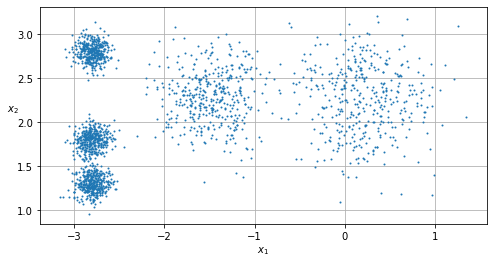

In [2]:
import matplotlib.pyplot as plt

def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$", rotation=0)

plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.gca().set_axisbelow(True)
plt.grid()


In [3]:
y_pred

array([0, 0, 4, ..., 3, 1, 0])

In [4]:
y_pred is kmeans.labels_

True

* For centroids:

In [5]:
kmeans.cluster_centers_

array([[-2.80214068,  1.55162671],
       [ 0.08703534,  2.58438091],
       [-1.46869323,  2.28214236],
       [-2.79290307,  2.79641063],
       [ 0.31332823,  1.96822352]])

In [6]:
X_new = np.array(
    [
        [0, 2],
        [3, 2],
        [-3, 3],
        [-3, 2.5]
    ]
    
)

kmeans.predict(X_new)

array([4, 4, 3, 3])

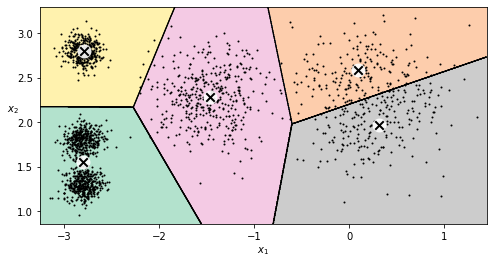

In [7]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$")
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)

plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)

* In the KMeans class, the transform() method measures the distance from each instance to every centroid:

In [8]:
kmeans.transform(X_new).round(2)

array([[2.84, 0.59, 1.5 , 2.9 , 0.31],
       [5.82, 2.97, 4.48, 5.85, 2.69],
       [1.46, 3.11, 1.69, 0.29, 3.47],
       [0.97, 3.09, 1.55, 0.36, 3.36]])

## Centroid initialization methods

* If you happen to know approximately where the centroids should be (e.g., if you ran another clustering algorithm earlier), then you can set the init hyperparameter to a NumPy array containing the list of centroids, and set n_init to 1:

In [9]:
good_init = np.array(
    [
        [-3, 3],
        [-3, 2],
        [-3, 1],
        [-1, 2],
        [0, 2]
    ]
)

kmeans = KMeans(n_clusters=5, init=good_init, n_init=1, random_state=42)

kmeans.fit(X)

KMeans(init=array([[-3,  3],
       [-3,  2],
       [-3,  1],
       [-1,  2],
       [ 0,  2]]),
       n_clusters=5, n_init=1, random_state=42)

* The number of random initializations is controlled by the n_init hyperparameter: by default it is equal to 10, which means that the whole algorithm described earlier runs 10 times when you call fit(), and Scikit-Learn keeps the best solution. But how exactly does it know which solution is the best? It uses a performance metric! That metric is called the model’s ``inertia``, which is the sum of the squared distances between the instances and their closest centroids.

In [10]:
kmeans.inertia_

211.5985372581684

In [13]:
kmeans.score(X)

-211.59853725816836